In [2]:
import sys
import math
import warnings

import psycopg2
import wrds
import gzip

import seaborn as sns
import os
import quandl
import json
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import functools
import requests
import io

import urllib.request
from urllib.error import HTTPError
# from html_table_parser.parser import HTMLTableParser
from bs4 import BeautifulSoup
import re

import plotnine as p9
from plotnine import ggplot, scale_x_date, guides, guide_legend, geom_bar, scale_y_continuous, \
    scale_color_identity, geom_line, geom_point, labs, theme_minimal, theme, element_blank, element_text, \
        geom_ribbon, geom_hline, aes, scale_size_manual, scale_color_manual, ggtitle

from datetime import datetime
import datetime

import pandas as pd
# import pandas_market_calendars as mcal
from pandas.plotting import autocorrelation_plot
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import scipy as sp
from scipy.stats import norm
import scipy.stats as stats

from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from collections import deque
from bisect import insort, bisect_left
from itertools import islice


In [3]:
datapull = pd.read_csv('spy_tickerdata.csv')

In [4]:
datapull

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,SPY,1993-08-13,45.093700,45.156200,45.093700,45.125000,103500.0,0.0,1.0,25.778428,25.814157,25.778428,25.796321,103500.0
1,SPY,1993-08-16,45.156200,45.500000,45.156200,45.375000,241800.0,0.0,1.0,25.814157,26.010695,25.814157,25.939237,241800.0
2,SPY,1993-08-17,45.343700,45.531200,45.343700,45.531200,369300.0,0.0,1.0,25.921344,26.028531,25.921344,26.028531,369300.0
3,SPY,1993-08-18,45.687500,45.875000,45.656200,45.781200,414300.0,0.0,1.0,26.117882,26.225069,26.099989,26.171447,414300.0
4,SPY,1993-08-19,45.812500,45.812500,45.718700,45.781200,28500.0,0.0,1.0,26.189340,26.189340,26.135718,26.171447,28500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,SPY,1993-06-22,44.656200,44.656200,44.562500,44.625000,137500.0,0.0,1.0,25.528325,25.528325,25.474761,25.510490,137500.0
7816,SPY,1994-11-16,46.765598,46.843700,46.609299,46.843700,106900.0,0.0,1.0,27.589587,27.635663,27.497377,27.635663,106900.0
7817,SPY,2010-03-10,114.510002,115.279999,114.410004,114.970001,186088800.0,0.0,1.0,87.964535,88.556033,87.887719,88.317898,186088800.0
7818,SPY,2022-02-15,443.730000,446.280000,443.180000,446.100000,88435136.0,0.0,1.0,430.043935,432.515285,429.510899,432.340837,88435136.0


In [5]:
csv_file_path = 'C:/Users/jrecc/Grad_School_Winter_2024/FINM_33150/Project/option_data.csv'
spydata = pd.read_csv(csv_file_path)

In [6]:
spydata['date']=pd.to_datetime(spydata['date'], format = '%Y-%m-%d')
spydata['exdate']=pd.to_datetime(spydata['exdate'], format = '%Y-%m-%d')
spydata['dte'] = (spydata['exdate'] - spydata['date']).dt.days

In [7]:
first_options = spydata[(spydata['exdate'] == '2018-04-04') & (spydata['dte'] < 30) & (spydata['dte'] >=7) & (spydata['strike_price'] == 245000)]

first_calls= first_options[first_options['cp_flag'] == 'C'].sort_values('date')
first_puts= first_options[first_options['cp_flag'] == 'P'].sort_values('date')

In [8]:
middle_options = spydata[(spydata['exdate'] == '2021-03-08') & (spydata['dte'] < 30) & (spydata['dte'] >=7) & (spydata['strike_price'] == 365000)]

middle_calls= middle_options[middle_options['cp_flag'] == 'C'].sort_values('date')
middle_puts= middle_options[middle_options['cp_flag'] == 'P'].sort_values('date')

In [9]:
last_options = spydata[(spydata['exdate'] == '2022-07-06') & (spydata['dte'] < 30) & (spydata['dte'] >=7) & (spydata['strike_price'] == 400000)]

last_calls= last_options[last_options['cp_flag'] == 'C'].sort_values('date')
last_puts= last_options[last_options['cp_flag'] == 'P'].sort_values('date')

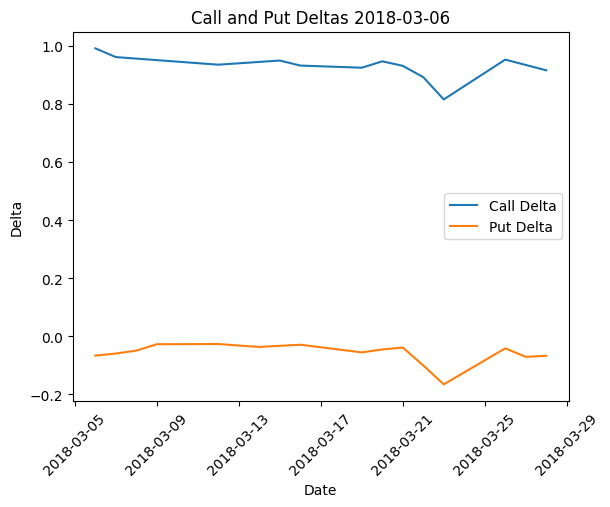

In [10]:
plt.plot(first_calls.set_index('date')['delta'].dropna())

plt.plot(first_puts.set_index('date')['delta'].dropna())
plt.legend(['Call Delta', 'Put Delta'])
plt.xlabel('Date')
plt.ylabel('Delta')
plt.title('Call and Put Deltas 2018-03-06')
plt.xticks(rotation = 45)
plt.show()

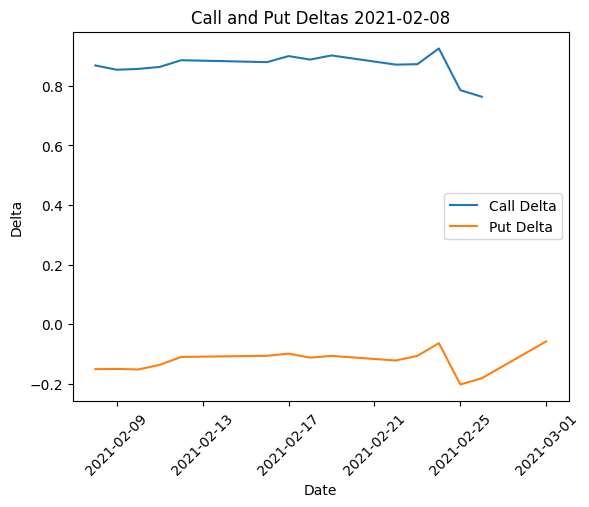

In [11]:
plt.plot(middle_calls.set_index('date')['delta'].dropna())

plt.plot(middle_puts.set_index('date')['delta'].dropna())
plt.title('Call and Put Deltas 2021-02-08')
plt.legend(['Call Delta', 'Put Delta'])
plt.xlabel('Date')
plt.ylabel('Delta')
plt.xticks(rotation = 45)


plt.show()

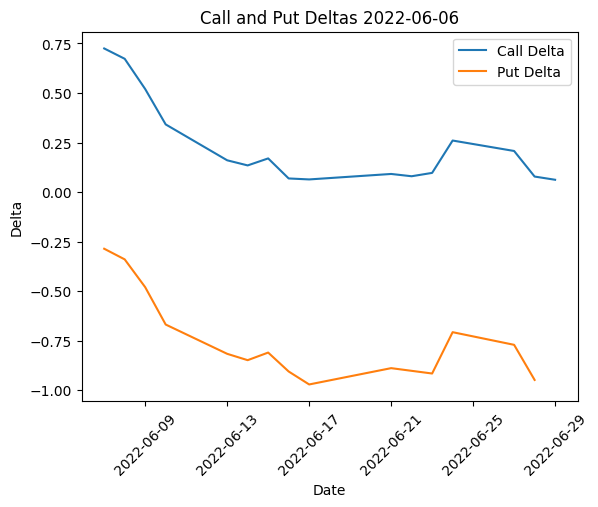

<Figure size 800x300 with 0 Axes>

In [12]:

plt.plot(last_calls.set_index('date')['delta'].dropna())

plt.plot(last_puts.set_index('date')['delta'].dropna())
plt.legend(['Call Delta', 'Put Delta'])
plt.title('Call and Put Deltas 2022-06-06')
plt.xlabel('Date')
plt.ylabel('Delta')
plt.xticks(rotation = 45)

plt.figure(figsize = (8, 3))
plt.show()

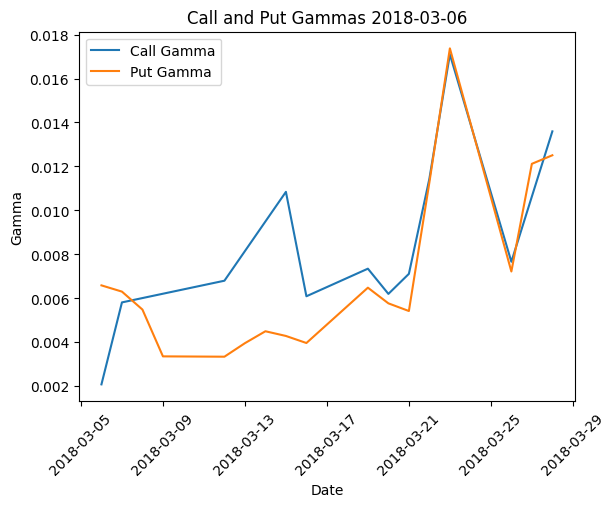

In [13]:
plt.plot(first_calls.set_index('date')['gamma'].dropna())

plt.plot(first_puts.set_index('date')['gamma'].dropna())
plt.legend(['Call Gamma', 'Put Gamma'])
plt.xlabel('Date')
plt.ylabel('Gamma')
plt.title('Call and Put Gammas 2018-03-06')
plt.xticks(rotation = 45)
plt.show()

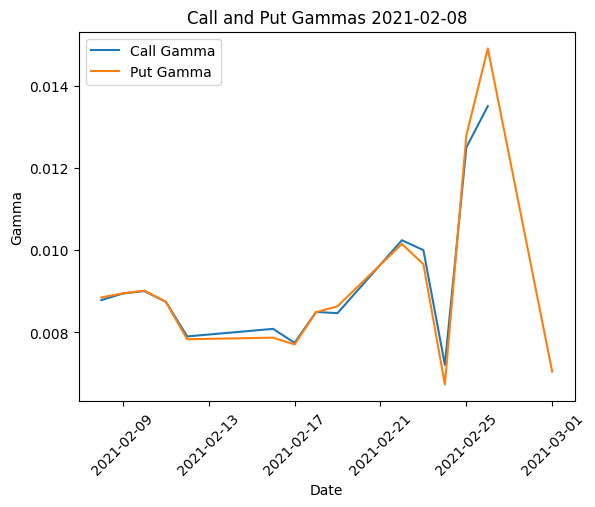

In [14]:
plt.plot(middle_calls.set_index('date')['gamma'].dropna())

plt.plot(middle_puts.set_index('date')['gamma'].dropna())
plt.title('Call and Put Gammas')
plt.legend(['Call Gamma', 'Put Gamma'])
plt.xlabel('Date')
plt.ylabel('Gamma')
plt.title('Call and Put Gammas 2021-02-08')
plt.xticks(rotation = 45)
plt.show()

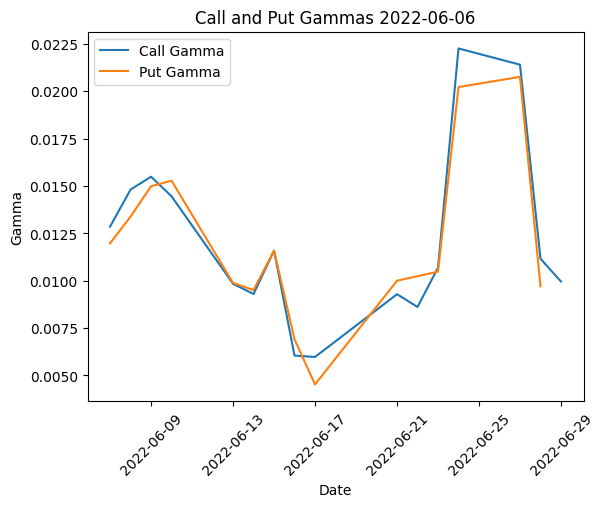

In [15]:
plt.plot(last_calls.set_index('date')['gamma'].dropna())

plt.plot(last_puts.set_index('date')['gamma'].dropna())
plt.legend(['Call Gamma', 'Put Gamma'])
plt.xlabel('Date')
plt.title('Call and Put Gammas 2022-06-06')
plt.ylabel('Gamma')
plt.xticks(rotation = 45)
plt.show()